In [1]:
import sys
# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
%matplotlib notebook
db_connect_params = {
    "host" : "185.117.118.107",
    "port" : 59000,
    "user" : "alex",
    "password" : "Xrxcmr758",
    "database" : "rt"
}

# Make dataset

In [3]:
import numpy as np
import pandas as pd

In [4]:
num = 30
lowest_ask = 96
highest_bid = 95
ts_start = 1000000
step = 1
period = 60

lowest_asks = np.arange(lowest_ask, lowest_ask + num, step).reshape(-1,1)
highest_bids = np.arange(highest_bid, highest_bid + num, step).reshape(-1,1)
ts = np.arange(ts_start, ts_start + num * period, period * step).reshape(-1,1)

dataset = np.concatenate([ts, lowest_asks, highest_bids], axis=1)
dataset = pd.DataFrame(dataset, columns = ["ts", "lowest_ask", "highest_bid"])
dataset = dataset.set_index("ts")
dataset

,lowest_ask,highest_bid
ts,,
1000000,96,95
1000060,97,96
1000120,98,97
1000180,99,98
1000240,100,99
1000300,101,100
1000360,102,101
1000420,103,102
1000480,104,103


# DataPoint

# Define Environment

In [ ]:
from core import RTCore
from core.context import BasicContext
from core.tickers import TickerOppositeTradesReward

from core.observation_builder import ObservationBuilderOrderbookOppositeTrade


from data_point import DataPointFactory
from train_tools import Player, plot_and_go, AgentTrainWrapper

In [6]:
from core.actions import TradeAction, OppositeTradeAction
from core.context import BasicContext

from data_point import DataPoint, DataPointFactory

from core.ticker import 

In [10]:
dpf = DataPointFactory(dataset, period=60, n_observation_points=10, n_history_points=0, n_future_points=0, step_size=None)

In [11]:
data_point = dpf.get_current_step()

In [12]:
data_point.__dict__

{'data':          lowest_ask  highest_bid
 ts                              
 1000000          96           95
 1000060          97           96
 1000120          98           97
 1000180          99           98
 1000240         100           99
 1000300         101          100
 1000360         102          101
 1000420         103          102
 1000480         104          103
 1000540         105          104,
 'fut_len': 0,
 'obs_len': 10,
 'hist_len': 0,
 'current_idx': 1000540,
 'start_idx': 1000000,
 'period': 60}

In [16]:
context = BasicContext(market_fee = 0.005)
context.update_datapoint(data_point)

In [17]:
context.__dict__

{'market_fee': 0.005,
 'data_point': <data_point.data_point.DataPoint at 0x7fa5b2b76730>,
 'trade': None,
 'params': {'Common': {'ts': 1000600, 'lowest_ask': 106, 'highest_bid': 105},
  'Data': {'data_point':          lowest_ask  highest_bid
   ts                              
   1000060          97           96
   1000120          98           97
   1000180          99           98
   1000240         100           99
   1000300         101          100
   1000360         102          101
   1000420         103          102
   1000480         104          103
   1000540         105          104
   1000600         106          105},
  'Trade': {'is_open_prev': False, 'is_open': False, 'profit': 0}}}

In [ ]:
trade = TradeAction(context)
context.set_trade(trade)

In [14]:
data_point, done = dpf.get_next_step()
context.update_datapoint(data_point)
print(done)

False


# Observation builder

In [50]:
from core.observation_builder import ObservationBuilderTrendIndicator

In [79]:
import logging
import numpy as np
from collections import deque

from core.observation_builder.interface import ObservationBuilderInterface

logger = logging.getLogger(__name__)


class ObservationBuilderTrendIndicator(ObservationBuilderInterface):
    SCALE_FACTOR = 10

    def __init__(self, context):
        self.context = context
        self.ti = None
        self.ti_date = None

    def reset(self):
        pass

    def get(self, data_point):
        # trade state feature
        trade_state = self.context.get("is_open", domain="Trade")

        # rates representation
        current_price = self.context.get("highest_bid")
        rates = (data_point.get_values("highest_bid").values / current_price - 1) * self.SCALE_FACTOR

        # profit representation
        profit = self._get_profit(data_point, trade_state)

        # trend indicator representation
        trend = self._get_trend_indicator(data_point)

        # observation
        static_data = [trade_state]

        conv_data = np.concatenate([
            rates.reshape(-1, 1),
            profit.reshape(-1, 1),
            trend.reshape(-1, 1),
        ], axis=1)

        observation = [
            np.array(static_data, dtype=np.float32),
            np.array(conv_data, dtype=np.float32)
        ]
        return observation

    def _get_profit(self, data_point, trade_state):
        trade = self.context.trade
        timestamps = data_point.get_timestamps()

        if trade is not None:
            mask = [trade.open_ts < ts < trade.close_ts for ts in timestamps]
            current_rates = data_point.get_values("highest_bid").values.copy()
            profit = current_rates / trade.open_price - 1 - self.context.market_fee
            profit = profit * mask * self.SCALE_FACTOR
        else:
            profit = np.zeros(len(timestamps))
        return profit
    
    
    def _get_trend_indicator(self, dp):
        if self.ti is None:
            self.ti = self._build_ti(dp)
            self.ti_date = dp.get_current_ts
        
        elif dp.get_current_ts > self.ti_date + dp.period:
            self.ti = self._build_ti(dp)
            self.ti_date = dp.get_current_ts
            
        elif dp.get_current_ts == self.ti_date:
            pass
        
        else:
            ti = self._get_ti(dp)
            self.ti.append(ti)
            self.ti_date = dp.get_current_ts
            
        return self.ti
            
    def _get_ti(self, dp, cursor=None):
        if cursor is None:
            cursor = dp.get_current_ts()
            
        if dp.n_future_points > 0:

            current_value = dp.get_value("highest_bid", cursor=cursor)
            future_values = dp.get_future_values("highest_bid", cursor=cursor).values

            diff = np.array(future_values / current_value - 1) * 100
            coeffs = np.linspace(1.0, 0.5, len(diff))

            trend_indicator = np.average(diff, weights=coeffs)
            return trend_indicator
        else:
            return 0

    def _build_ti(self, dp):
        ti_arr = deque(maxlen = len(dp.get_timestamps()))
        indexes = dp.get_timestamps()
        for cursor in indexes:
            ti = get_ti(dp, cursor=cursor)
            ti_arr.append(ti)
        return ti_arr

In [80]:
obti = ObservationBuilderTrendIndicator(context)

In [81]:
trade.__dict__

{'id': 'cdef13ff-f213-4517-9ac8-da88cf7de65d',
 'context': <core.context.basic_context.BasicContext at 0x7f90eaa922b0>,
 'open_ts': 1001200,
 'open_price': 100,
 'market_fee': 0.005,
 'close_ts': 9223372036854775807,
 'close_price': None,
 'is_open': True,
 'trade_volume': 0,
 'profit': -0.015}

In [82]:
obti._get_profit(data_point, trade.is_open)

array([-0.  , -0.  , -0.  , -0.  , -0.05])

In [85]:
obti._get_trend_indicator(data_point)

deque([1.8518518518518527,
       1.832760595647187,
       1.8140589569160948,
       1.7957351290684618,
       1.7777777777777795])

In [65]:
def get_ti(dp, cursor=None):
    if cursor is None:
        cursor = dp.get_current_ts()

    current_value = dp.get_value("highest_bid", cursor=cursor)
    future_values = dp.get_future_values("highest_bid", cursor=cursor).values

    diff = np.array(future_values / current_value - 1) * 100
    coeffs = np.linspace(1.0, 0.5, len(diff))

    trend_indicator = np.average(diff, weights=coeffs)
        
    return trend_indicator

ti = get_ti(data_point)
ti  
    

1.7777777777777795

In [74]:
from collections import deque


def build_ti(dp):
    ti_arr = deque(maxlen=3)
    indexes = dp.get_timestamps()
    for cursor in indexes:
        ti = get_ti(dp, cursor=cursor)
        ti_arr.append(ti)
    return ti_arr
ti_arr = build_ti(data_point)
print(ti_arr)

deque([1.8140589569160948, 1.7957351290684618, 1.7777777777777795], maxlen=3)


In [70]:
q = deque(maxlen=10)

In [71]:
q

deque([])

In [38]:
def get_current_ti(data_point, cursor=):
    current_value = data_point.get_value("highest_bid")
    future_values = data_point.get_future_values("highest_bid").values
    percentage = np.array(future_values / current_value - 1) * 100
    coeffs = np.linspace(1.0, 0.5, len(percentage))

    if len(coeffs):
        trend_indicator = np.average(percentage, weights=coeffs)
    else:
        trend_indicator = 0
        
    return trend_indicator
    
ti = get_current_ti(data_point)
ti


1.7777777777777795

In [42]:
common_df = pd.concat([data_point.data, data_point.data_f])

ts_list = data_point.get_timestamps()
for ts in ts_list:
    current_value = data_point.get_value("highest_bid", cursor=ts)
    future_values = data_point.get_future_values("highest_bid").values

96
97
98
99
100


In [24]:
common_df

,lowest_ask,highest_bid
ts,,
1000300,97,96
1000600,98,97
1000900,99,98
1001200,100,99
1001500,101,100
1001800,102,101
1002100,103,102
1002400,104,103


In [25]:
data_point.__dict__

{'data':          lowest_ask  highest_bid
 ts                              
 1000300          97           96
 1000600          98           97
 1000900          99           98
 1001200         100           99
 1001500         101          100,
 'data_f':          lowest_ask  highest_bid
 ts                              
 1001800         102          101
 1002100         103          102
 1002400         104          103,
 'current_index': 1001500,
 'offset': 5}

# Download dataset

In [3]:
from data_providers import ClickHouseConnector
from data_providers import DbDataProvider
from train_tools import plot_and_go

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


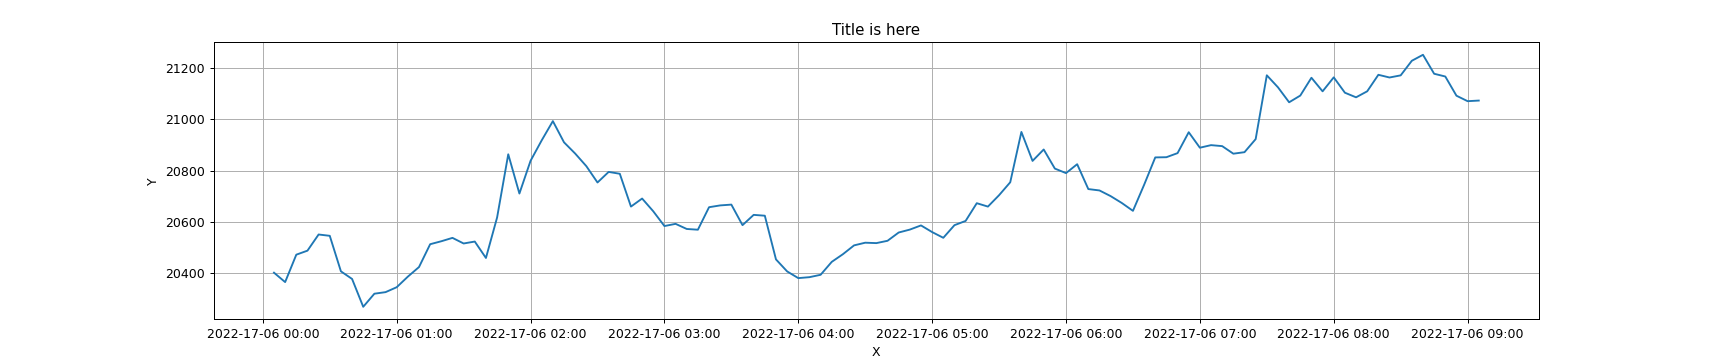

(109, 3)


In [4]:
pair = "USDT_BTC"
start = "2022-06-17 00:00:00"
end = "2022-06-17 09:00:00"
period = 300

with ClickHouseConnector(db_connect_params) as connector:
    
    data_provider = DbDataProvider(connector)
    data = data_provider.get(start, end, period, pairs=["USDT_BTC"])
    
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)




# Create DataPoint Factory

In [6]:
import sys
import numpy as np

from data_point import DataPoint
from data_point import DataPointFactory

In [7]:
dpf = DataPointFactory(dataset=data, period=300, n_observation_points=7, n_future_points=3, step_size=None)

In [8]:
data_point = dpf.get_current_step()
data_point.__dict__

{'data':                 pair   highest_bid    lowest_ask
 ts                                              
 1655424300  USDT_BTC  20387.285156  20402.664062
 1655424600  USDT_BTC  20360.287109  20366.050781
 1655424900  USDT_BTC  20469.771484  20472.669922
 1655425200  USDT_BTC  20470.207031  20488.300781
 1655425500  USDT_BTC  20551.001953  20551.150391
 1655425800  USDT_BTC  20542.328125  20546.039062
 1655426100  USDT_BTC  20404.300781  20407.880859,
 'data_f':                 pair   highest_bid    lowest_ask
 ts                                              
 1655426400  USDT_BTC  20368.960938  20378.275391
 1655426700  USDT_BTC  20265.000000  20269.988281
 1655427000  USDT_BTC  20310.394531  20320.914062,
 'current_index': 1655426100,
 'offset': 7}

In [10]:
data_point.get_timestamps()

array([1655424300, 1655424600, 1655424900, 1655425200, 1655425500,
       1655425800, 1655426100])

In [11]:
open_ts = 1655424900
close_ts = 1655425500 #sys.maxsize

mask = [ open_ts < ts and ts < close_ts for ts in data_point.get_timestamps()]
mask

[False, False, False, True, False, False, False]

In [18]:
current_rates = data_point.get_values("highest_bid").values.copy()
current_rates

array([20387.285, 20360.287, 20469.771, 20470.207, 20551.002, 20542.328,
       20404.3  ], dtype=float32)

In [13]:
open_price = 20000.01
market_fee = 0.005
profit = current_rates / open_price - 1 - market_fee
profit

array([0.01436376, 0.01301384, 0.01848805, 0.01850986, 0.02254963,
       0.02211594, 0.01521456], dtype=float32)

In [14]:
mask * profit

array([0.        , 0.        , 0.        , 0.01850986, 0.        ,
       0.        , 0.        ], dtype=float32)

In [28]:
def check_feat(features, method):
    result = []
    for feat in features:
        if isinstance(feat, list):
            result = check_feat(feat, method)
        else
            m = getattr(feat, method)
            result = m()
            
            
            handler = 
        reward, action_result = handler(ts, is_open)
        
       

True
False
